# Linear Gaussian example

The function is $y=\theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \epsilon = X \theta + \epsilon$. The NN is composed simply of 2 inputs and 1 output, no hidden layer, and a linear activation function. The data is $D = \lbrace X, y \rbrace=\lbrace x_{1}, x_{2}, y\rbrace$.

The prior is chosen to be Gaussian, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior})  $, and so is the noise $\epsilon \sim N(\cdot; 0, \sigma_{n}^{2} I)$. Then the posterior of the parameters can be computed analytically as:

\begin{align*}
& p(\theta \vert D={x,y}) =  N(\cdot; \theta_{post}(D), \Sigma_{post}(D)) \\
& \theta_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1} \left(\frac{1}{\sigma_{n}^{2}}X^{T}y+\Sigma^{-1}\theta_{prior} \right) \\
& \Sigma_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1}
\end{align*}

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.examples_utils import *
from scipy.stats import multivariate_normal

from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# compute the true posterior pdf based on available data
def compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n):
    X = np.concatenate([np.ones((xn.shape[0], 1)), xn], axis=1)
    
    # compute posterior pdf
    S_posterior = np.linalg.inv(1/var_n*np.matmul(X.T,X)+np.linalg.inv(S_prior))
    m_posterior = np.matmul(
        S_posterior, 
        1/var_n*np.matmul(X.T, yn)+np.matmul(np.linalg.inv(S_prior), m_prior.reshape((-1,1)))
        )
    m_posterior = m_posterior.reshape((-1,))
    return m_posterior, S_posterior

def compute_gaussian_pdf(x, mean, std):
    log2pi = np.log(2 * np.pi).astype(np.float32)
    return np.exp(- 0.5 * log2pi - np.log(std) - 0.5 * np.square(np.divide(np.subtract(x, mean), std)))

## First problem: the posterior pdf is Gaussian with (almost) independent marginals

[-0.76743446  1.29565096  0.85033956]
[0.14212819 0.18668154 0.4040091 ]
[[ 0.02020042  0.00450616  0.00021966]
 [ 0.00450616  0.03485    -0.00808852]
 [ 0.00021966 -0.00808852  0.16322335]]
rho = -0.10724488778282412


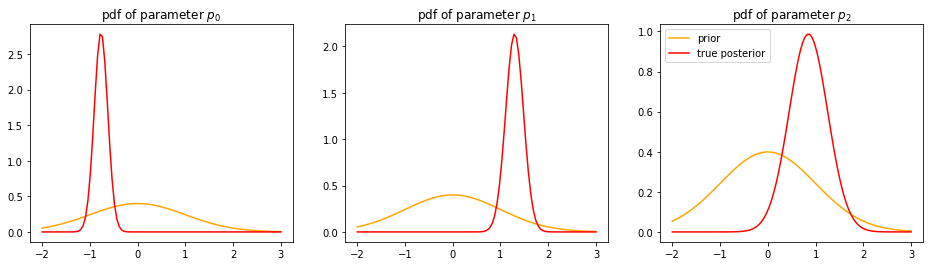

In [3]:
# define the problem
var_n = 1.
f = lambda x, noisy: (-0.5+1.*x[:, 0]+1.7*x[:, 1]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([np.cos(xn), 0.5*np.sin(xn**2)], axis=1)
yn = f(xn, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
print('rho = {}'.format(S_posterior[1,2]/np.sqrt(S_posterior[1,1]*S_posterior[2,2])))
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter $p_{}$'.format(p))
ax[2].legend()
plt.show(fig)

In [4]:
# define the network
units_per_layer = () # no hidden layers
prior = {'type': 'gaussian', 'variance': [1]} # only needed for output layer
pre_model = None
#pre_model = build_scaling_layers(X_train=xn)

In the following we test several algorihtms and look at the posterior pdf (in particular uncertainty on parameter p2 should be smaller than uncertainty on parameter p0).

### Test BayesByBackprop

In [5]:
reg = BayesByBackprop(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
                      input_dim=2, output_dim=1, 
                      var_n=var_n, activation='linear', n_weights_to_track=2)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=10000, lr=0.001)

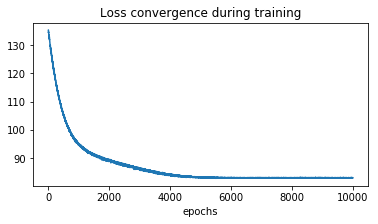

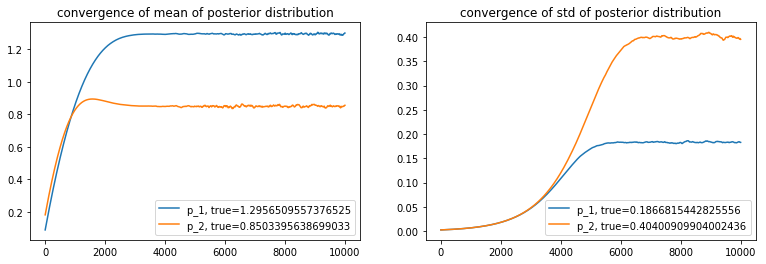

In [6]:
# plot the loss and parameter learning
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(reg.loss_history[:, 0])
ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
plt.show(fig)

fig, ax = plt.subplots(ncols=2, figsize=(13,4))
for i in range(2):
    ax[0].plot(reg.theta_history[:, i, 0], label = 'p_{}'.format(i+1)+', true={}'.format(m_posterior[i+1]))
    ax[1].plot(reg.theta_history[:, i, 1], 
               label = 'p_{}'.format(i+1)+', true={}'.format(np.sqrt(np.diag(S_posterior)[i+1])))
ax[0].set_title('convergence of mean of posterior distribution')
ax[1].set_title('convergence of std of posterior distribution')
ax[0].legend(); ax[1].legend()
plt.show(fig)

### Test alpha-BB algorithm

In [7]:
reg = alphaBB(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
              input_dim=2, output_dim=1, 
              var_n=var_n, activation='linear', n_weights_to_track=2,
              alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=10000, lr=0.001)

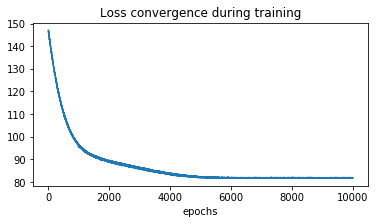

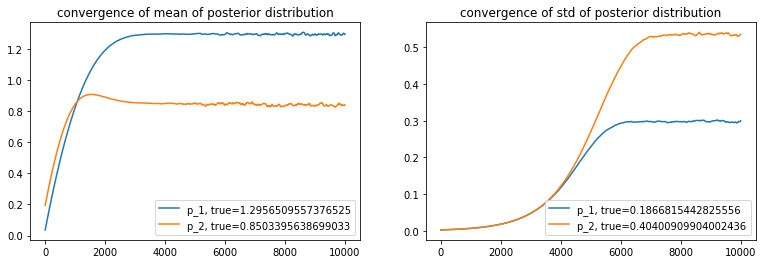

In [8]:
# plot the loss and parameter learning
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(reg.loss_history[:])
ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
plt.show(fig)

fig, ax = plt.subplots(ncols=2, figsize=(13,4))
for i in range(2):
    ax[0].plot(reg.theta_history[:, i, 0], label = 'p_{}'.format(i+1)+', true={}'.format(m_posterior[i+1]))
    ax[1].plot(reg.theta_history[:, i, 1], 
               label = 'p_{}'.format(i+1)+', true={}'.format(np.sqrt(np.diag(S_posterior)[i+1])))
ax[0].set_title('convergence of mean of posterior distribution')
ax[1].set_title('convergence of std of posterior distribution')
ax[0].legend(); ax[1].legend()
plt.show(fig)

## Second problem: the posterior pdf is Gaussian with dependent marginals

[-0.52402334  1.01731379  1.55124734]
[0.28813833 0.0655318  0.20788423]
[[ 0.0830237  -0.01184908 -0.00096122]
 [-0.01184908  0.00429442 -0.00930081]
 [-0.00096122 -0.00930081  0.04321585]]
rho = -0.6827267038083091


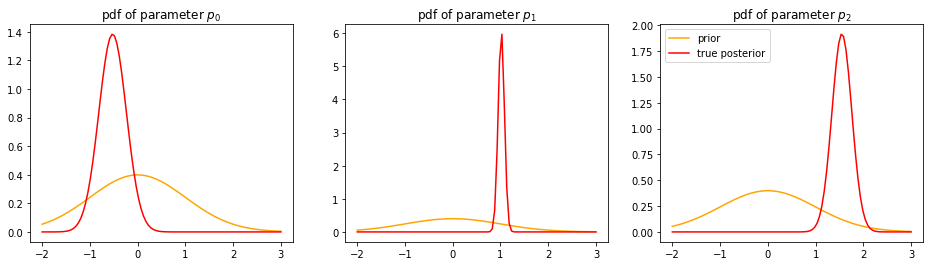

In [35]:
# define the problem
var_n = 1.
f = lambda x, noisy: (-0.5+1.*x[:, 0]+1.7*x[:, 1]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([xn, 0.2*xn+np.sin(xn)], axis=1)
yn = f(xn, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
print('rho = {}'.format(S_posterior[1,2]/np.sqrt(S_posterior[1,1]*S_posterior[2,2])))
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter $p_{}$'.format(p))
ax[2].legend()
plt.show(fig)

# define the network
units_per_layer = () # no hidden layers
prior = {'type': 'gaussian', 'variance': [1]} # only needed for output layer
pre_model = None
#pre_model = build_scaling_layers(X_train=xn)

### BayesByBackprop

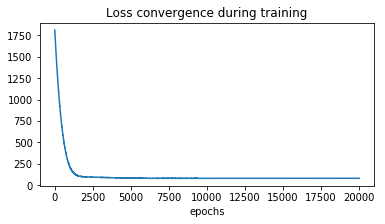

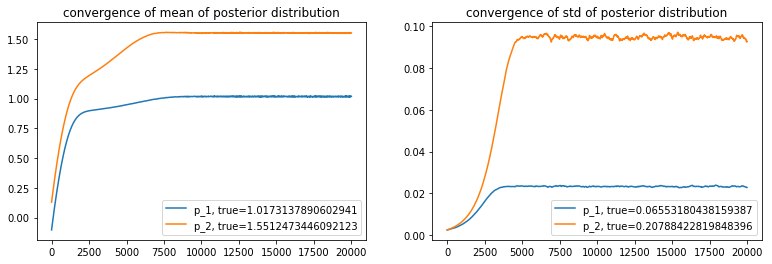

In [36]:
reg = BayesByBackprop(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
                      input_dim=2, output_dim=1, 
                      var_n=var_n, activation='linear', n_weights_to_track=2)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(reg.loss_history[:, 0])
ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
plt.show(fig)

fig, ax = plt.subplots(ncols=2, figsize=(13,4))
for i in range(2):
    ax[0].plot(reg.theta_history[:, i, 0], label = 'p_{}'.format(i+1)+', true={}'.format(m_posterior[i+1]))
    ax[1].plot(reg.theta_history[:, i, 1], 
               label = 'p_{}'.format(i+1)+', true={}'.format(np.sqrt(np.diag(S_posterior)[i+1])))
ax[0].set_title('convergence of mean of posterior distribution')
ax[1].set_title('convergence of std of posterior distribution')
ax[0].legend(); ax[1].legend()
plt.show(fig)

### alpha BB algorithm

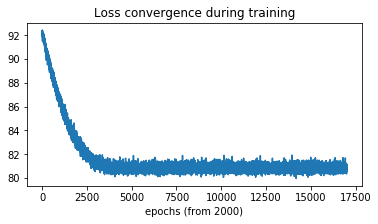

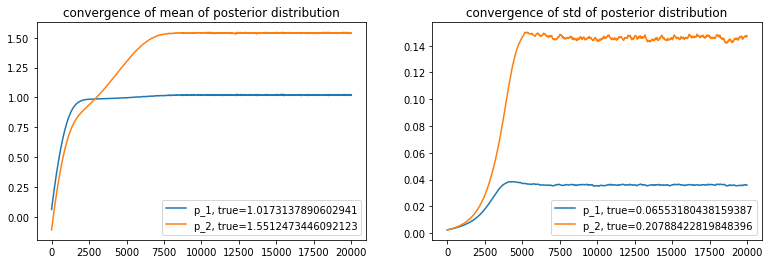

In [37]:
reg = alphaBB(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
              input_dim=2, output_dim=1, 
              var_n=var_n, activation='linear', n_weights_to_track=2,
              alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(reg.loss_history[3000:])
ax.set_xlabel('epochs (from 2000)'); ax.set_title('Loss convergence during training')
plt.show(fig)

fig, ax = plt.subplots(ncols=2, figsize=(13,4))
for i in range(2):
    ax[0].plot(reg.theta_history[:, i, 0], label = 'p_{}'.format(i+1)+', true={}'.format(m_posterior[i+1]))
    ax[1].plot(reg.theta_history[:, i, 1], 
               label = 'p_{}'.format(i+1)+', true={}'.format(np.sqrt(np.diag(S_posterior)[i+1])))
ax[0].set_title('convergence of mean of posterior distribution')
ax[1].set_title('convergence of std of posterior distribution')
ax[0].legend(); ax[1].legend()
plt.show(fig)

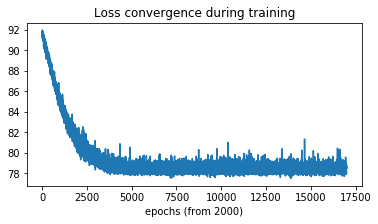

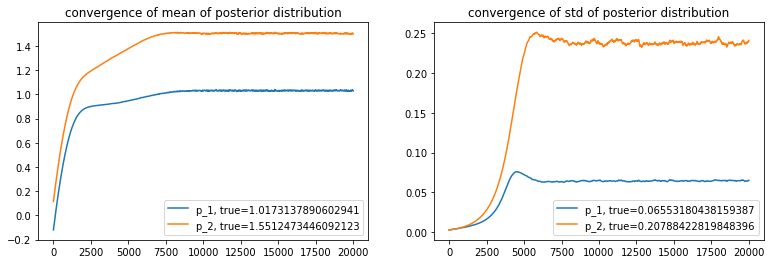

In [38]:
reg = alphaBB(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
              input_dim=2, output_dim=1, 
              var_n=var_n, activation='linear', n_weights_to_track=2,
              alpha=0.99)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(reg.loss_history)
ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
plt.show(fig)

fig, ax = plt.subplots(ncols=2, figsize=(13,4))
for i in range(2):
    ax[0].plot(reg.theta_history[:, i, 0], label = 'p_{}'.format(i+1)+', true={}'.format(m_posterior[i+1]))
    ax[1].plot(reg.theta_history[:, i, 1], 
               label = 'p_{}'.format(i+1)+', true={}'.format(np.sqrt(np.diag(S_posterior)[i+1])))
ax[0].set_title('convergence of mean of posterior distribution')
ax[1].set_title('convergence of std of posterior distribution')
ax[0].legend(); ax[1].legend()
plt.show(fig)